In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from functools import partial
from scipy.stats import f, ncf
from sklearn.metrics import r2_score
from tqdm.notebook import trange
from utils import *
from estimators import ClusteredSegmentation

In [2]:
p, n = 10, 15_000
rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
y = rg()['y'].to_numpy().reshape(-1,1)
cluster = ClusteredSegmentation(n_clusters = 40)
cluster.fit(X, y)
tau = cluster.tau_metric
tau, tau.tau_est, tau.tau_LB

(tau(n=15000, p=1024, q=40, r_sqf=0.9452067821225649, r_sqr=0.9438502416046506, alpha=0.05),
 0.024757453029109096,
 1.1377093190091492e-16)

In [3]:
rg.config.coefficient_generator_config

{'distribution': 'Gauss',
 'mean': 4.737194728452003,
 'error': 6.208691011757847}

In [4]:
cluster.MSE, rg.config.sigma**2

(43.72785850069325, 45.895396799670074)

In [5]:
from BarcodeScanner import barcodeScanner

scanner = barcodeScanner(estimator = cluster, config = rg.config)
scanner.raw_contrast, scanner.missingPairsMLE()

(<946x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 57947 stored elements in Compressed Sparse Row format>,
 <38x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 38 stored elements in Compressed Sparse Column format>)

In [6]:
scanner.weighted_segment_means

0     [1.0, 0.7037037037037037, 1.0, 0.7037037037037...
1     [1.0, 0.15, 1.0, 0.5333333333333333, 0.9333333...
2     [1.0, 0.15294117647058825, 1.0, 0.764705882352...
3     [1.0, 0.3669064748201439, 1.0, 0.1438848920863...
4     [1.0, 0.5130434782608696, 0.7043478260869566, ...
5     [1.0, 0.0, 1.0, 0.23008849557522124, 1.0, 0.59...
6     [0.6770833333333334, 0.23958333333333334, 0.94...
7     [0.8804347826086957, 0.3695652173913043, 0.887...
8     [0.8247422680412371, 0.48109965635738833, 0.80...
9     [0.903137789904502, 0.18417462482946795, 0.817...
10    [0.8576271186440678, 0.31864406779661014, 0.71...
11    [0.637478108581436, 0.22416812609457093, 0.660...
12    [0.7168539325842697, 0.4898876404494382, 0.566...
13    [0.802547770700637, 0.5138004246284501, 0.5987...
14    [0.7472527472527473, 0.5384615384615384, 0.534...
15    [0.7896678966789668, 0.7398523985239852, 0.551...
16    [0.702846975088968, 0.7135231316725978, 0.5195...
17    [0.740880503144654, 0.6855345911949685, 0.

#### This is where to begin next time

In [7]:
scanner.missing_arrays[:5]

[array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int8),
 array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1], dtype=int8)]

In [8]:
cluster.full_to_reduced.shape

(986, 1)

In [9]:
len(scanner.missing_arrays)

38

### Euclidean Distance

In [10]:
scanner.assign_missing_euclidean.sort_values('full')

,full,reduced
0,0,18
1,1,19
2,2,15
3,3,16
4,4,17
...,...,...
1019,1019,1
1020,1020,8
1021,1021,24
1022,1022,4


### Mahalanobis Distance

In [11]:
from sklearn.covariance import EmpiricalCovariance

#### Case 1: Mahalanobis distance with covariance of each segment

In [12]:
table = scanner.segmentation_table.copy()
table['barcode'] = table.apply(lambda x: scanner.num_to_barcode(x['full'], 10).toarray()[0], axis = 1)

In [13]:
table

,full,reduced,counts,barcode
0,0,18,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,19,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,2,15,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,3,16,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
4,4,17,11,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...
981,1019,1,9,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1]"
982,1020,8,53,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]"
983,1021,24,14,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1]"
984,1022,4,16,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"


In [14]:
reduced = np.sort(table.reduced.unique())
covs = []
for r in reduced:
    barcodes = []
    r_table = table.loc[table.reduced.eq(r), ['barcode','counts']]
    for b, c in zip(r_table.barcode, r_table['counts']):
        barcodes += [b for _ in range(c)]
    barcodes = np.concatenate(barcodes).reshape(-1, 10)
    cov = EmpiricalCovariance()
    cov.fit(barcodes)
    covs.append(cov)

#### What we need : covs and table with the variable `barcode`

In [15]:
scanner.assign_missing_mahalanobis(pooled = False)

,full,reduced
0,0,18
1,1,19
2,2,15
3,3,16
4,4,17
...,...,...
1019,1019,1
1020,1020,8
1021,1021,24
1022,1022,4


[]

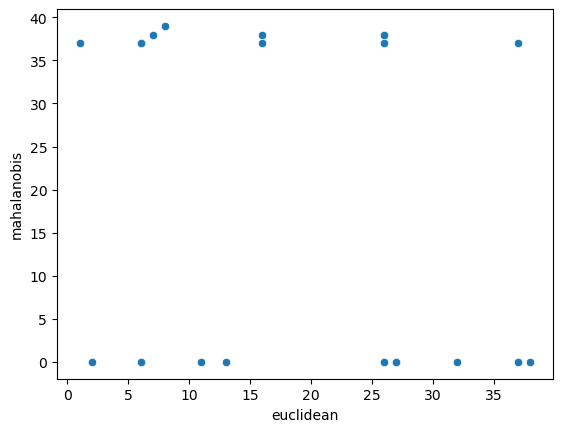

In [16]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_mahalanobis(pooled = False).loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','mahalanobis'])
sns.scatterplot(data = df, x = 'euclidean', y = 'mahalanobis', ax = ax)
plt.plot()

#### Case 2: Mahalanobis distance with pooled covariance

In [26]:
scanner.assign_missing_mahalanobis(pooled = True)

,full,reduced
0,0,18
1,1,19
2,2,15
3,3,16
4,4,17
...,...,...
1019,1019,1
1020,1020,8
1021,1021,24
1022,1022,4


[]

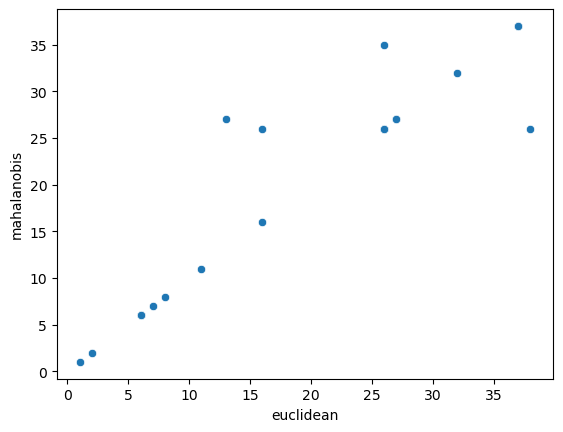

In [28]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_mahalanobis(pooled = True).loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','mahalanobis'])
sns.scatterplot(data = df, x = 'euclidean', y = 'mahalanobis', ax = ax)
plt.plot()

## Jensen-Shannon  distance

Need more time